# Disjunctive Programming

TODO: Rewrite following new style guide

TODO: MS ... contrast bigm vs gdp

## Television advertising

A business manager for a local television station needs to select advertisements for a 120 second slot during an evening news broadcast. The station's sales department has prepared a list of candidate advertisements detailing the client, ad titile, length in seconds, and the revenue eared by running the ad in that  time slot.

| Client | Title | Length | Revenue |
| :----- | :---- | :----: | :-----: |
| Super Cola | "Best Cola Ever" | 30 | 520 |
| Cheap Cola | "Good Cola, Low Price" | 15 | 250 |
| Corner Mart | "20% off sale" | 15 | 300 |
| Pat Smith for Mayo  | "Vote Smith for Mayor" | 30 | 600 |
| Pat Smith for Mayor | "Vote Smith for Mayor" | 60 | 1300 |
| Pat Smith for Mayor | "Vote Smith for Mayor" | 15 | 400 |
| Central Grocers | "Great coffee" | 10 | 250 |
| Quick Auto | "Good cars at low prices" | 15 | 280 |
| Fancy Auto | "Fancy cars at high prices" | 30 | 480 |
| Hollywood Studios | "Professor MegaMath saves the World" | 30 | 540 |
| Childrens Book Store | "Funny Stories" | 15 | 10 | 200 |

Any unfilled time 5 seconds or longer would be use to promote other programming with an assumed value of 10 &euro; per seconnd. 

There are some additional considerations in selecting ads for thi

In [82]:
import pandas as pd

ads = pd.DataFrame([
        ["Super Cola", "Best Cola Ever", 30, 520],
        ["Cheap Cola", "Good Cola, Low Price", 15, 250],
        ["Corner Mart", "20% Sale", 15, 300],
        ["Pat Smith for Mayor", "Vote Smith for Mayor", 30, 600],
        ["Pat Smith for Mayor", "Vote Smith for Mayor", 60, 1300],
        ["Pat Smith for Mayor", "Vote Smith for Mayor", 15, 400],
        ["Central Grocers", "Great Coffee", 10, 250],
        ["Quick Auto", "Good Cars at Low Prices", 15, 200],
        ["Fancy Auto", "Better Cars", 30, 400],
        ["Hollywood Studios", "Professor MegaMeth Saves the World", 30, 540],
        ["Children's Bookstore", "Funny Story Books", 15, 200],
    ],
    columns  = ["client", "title", "length", "revenue"])

# these are competitors that should not appear in the same time slot
conflicts = [
    ["Corner Mart", "Central Grocers"],
    ["Super Cola", "Cheap Cola"],
    ["Quick Auto", "Fancy Auto"]
]

# these are clients that wish to cross promotion
joint_promotions = [
    ["Corner Mart", "Cheap Cola"],
    ["Central Grocers", "Super Cola"]
]

display(ads)

,client,title,length,revenue
0,Super Cola,Best Cola Ever,30,520
1,Cheap Cola,"Good Cola, Low Price",15,250
2,Corner Mart,20% Sale,15,300
3,Pat Smith for Mayor,Vote Smith for Mayor,30,600
4,Pat Smith for Mayor,Vote Smith for Mayor,60,1300
5,Pat Smith for Mayor,Vote Smith for Mayor,15,400
6,Central Grocers,Great Coffee,10,250
7,Quick Auto,Good Cars at Low Prices,15,200
8,Fancy Auto,Better Cars,30,400
9,Hollywood Studios,Professor MegaMeth Saves the World,30,540


In [102]:
import pyomo.environ as pyo

def build_ad_model(ads, time_slot, conflicts):

    m = pyo.ConcreteModel()

    m.ADS = pyo.Set(initialize=ads.index)
    m.CLIENTS = pyo.Set(initialize=list(set(ads["client"])))
    m.CLIENT_ADS = pyo.Set(m.CLIENTS, 
                            initialize=lambda m, client: ads[ads["client"]==client].index)
    
    for client in m.CLIENT_ADS:
        print(client, [ad for ad in m.CLIENT_ADS[client]])


    m.x = pyo.Var(m.ADS, domain=pyo.Binary)
    
    @m.Objective(sense=pyo.maximize)
    def maximize_revenue(m):
        return sum(m.x[i] * ads.loc[i, "revenue"] for i in m.ADS)
    
    @m.Constraint()
    def max_time(m):
        return sum(m.x[i] * ads.loc[i, "length"] for i in m.ADS) <= time_slot
    
   # @m.Constraint(m.CLIENTS)
   # def no_repeat_clients(m, client):
   #     client_ads = ads[ads["client"]==client].index
   #     return sum(m.x[i] for i in client_ads) <= 1  
    
    @m.Constraint(m.CLIENT_ADS)
    def no_repeat_client(m, client):
        print(m.CLIENT_ADS[client])
        return sum([m.x[ad] for ad in m.CLIENT_ADS[client]]) <= 1
    
    @m.Disjunction(xor=True)
    def test(m):
        return [[m.x[2] == 1, m.x[4]==0], [m.x[2] == 0, m.x[4]==1]]
    
    pyo.TransformationFactory('gdp.hull').apply_to(m)
    solver = pyo.SolverFactory('cbc')
    solver.solve(m)
    
    soln = ads.copy()
    soln["run"] = [int(m.x[i]()) for i in m.ADS]
    
    return soln[soln["run"] == 1]

run_ads = build_ad_model(ads, 120, conflicts)


display(run_ads)
print(run_ads["length"].sum())
print(run_ads["revenue"].sum())

Fancy Auto [8]
Hollywood Studios [9]
Pat Smith for Mayor [3, 4, 5]
Cheap Cola [1]
Children's Bookstore [10]
Super Cola [0]
Central Grocers [6]
Corner Mart [2]
Quick Auto [7]


TypeError: Cannot apply a Set operator to an indexed Set component (CLIENT_ADS)

## Logical Relationships

MIT OpenCourseWare example: https://ocw.mit.edu/courses/sloan-school-of-management/15-053-optimization-methods-in-management-science-spring-2013/tutorials/MIT15_053S13_tut09.pdf


Example: Assign advertisers to television ad slots



In [4]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

m = pyo.ConcreteModel()

pyo.TransformationFactory("gdp.bigm").apply_to(m)
pyo.SolverFactory("gurobi_direct").solve(m)

{'Problem': [{'Name': 'unknown', 'Lower bound': 0.0, 'Upper bound': 0.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 0, 'Number of nonzeros': 0, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.51', 'Status': 'ok', 'Wallclock time': 0.00021505355834960938, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Disjunctive programming describes a class of optimization problems that include disjunctive ("or") constraints. These are encountered when there is a choice to be made, such as whether to do perform job A before job B on a machine, or use raw supplier X rather than Y in a supply chain, or open a retail store at location A, B, C, or D in a metropolitan area. 

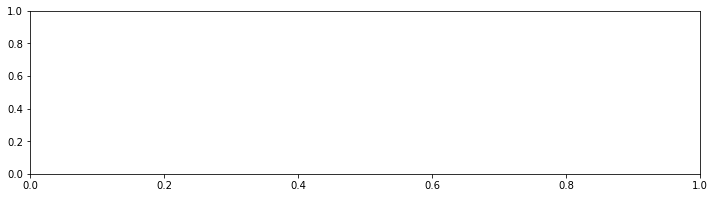

In [261]:
import random
import matplotlib.pyplot as plt

n_boxes = 10

boxes = dict()
for n in range(n_boxes):
    w = random.randint(10, 30)
    h = random.randint(10, 30)
    boxes[n] = {"W": w, "H": h, "D": }
    
print(boxes)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
x = 0
for box in boxes.keys():
    ax.rectangle(

In [260]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

m = pyo.ConcreteModel()

m.BOXES = pyo.Set(initialize=boxes.keys())
m.width_on_shelf = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, 50))
m.orientation = pyo.Var(m.BOXES, domain=pyo.NonNegativeIntegers, bounds=(1, 3))

@m.Objective(sense=pyo.minimize)
def shelf_width(m):
    return sum(m.width_on_shelf[box] for box in m.BOXES)

@m.Disjunction(m.BOXES, xor=True)
def orient_box(m, box):
    return [[m.orientation[box]==1, 
             m.width_on_shelf[box]==boxes[box]["W"]],
            
            [m.orientation[box]==2,
             m.width_on_shelf[box]==boxes[box]["H"]],
            
             [m.orientation[box]==3,
             m.width_on_shelf[box]==boxes[box]["D"]],
           ]

pyo.TransformationFactory("gdp.bigm").apply_to(m)
pyo.SolverFactory("cbc").solve(m)

for box in m.BOXES:
    print(f"Box {box:3d}  Orientation {m.orientation[box]()}  Width on Shelf {m.width_on_shelf[box]():4.1f}")

Box   0  Orientation 1.0  Width on Shelf 11.0
Box   1  Orientation 3.0  Width on Shelf 18.0
Box   2  Orientation 2.0  Width on Shelf 16.0
Box   3  Orientation 3.0  Width on Shelf 12.0
Box   4  Orientation 1.0  Width on Shelf 24.0
Box   5  Orientation 1.0  Width on Shelf 15.0
Box   6  Orientation 3.0  Width on Shelf 13.0
Box   7  Orientation 2.0  Width on Shelf 16.0
Box   8  Orientation 2.0  Width on Shelf 12.0
Box   9  Orientation 1.0  Width on Shelf 10.0


Suppose we have a set of items to deliver to customer that need to bo packaged into boxes for express shipping. Express shipping requires each package to weigh less than 30 kg. 



In [241]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

# data dictionary
weights = {"A": 12, "B": 8, "C": 20, "D": 10, "E": 25}

m = pyo.ConcreteModel()

m.BOXES = pyo.RangeSet(3)
m.ITEMS = pyo.Set(initialize=weights.keys())

m.assign = pyo.Var(m.ITEMS, m.BOXES, domain=pyo.Binary)
m.use_box = pyo.Var(m.BOXES, domain=pyo.Binary)

@m.Disjunction(m.ITEMS, xor=True)
def assign_item_to_one_box(model, item):
    return [[m.assign[item, box] == 1, m.use_box[box] == 1] for box in m.BOXES]

@m.Disjunction(m.BOXES, xor=True)
def assign_all_items(model, box):
    return [m.assign[item, box] == 1 for item in m.ITEMS]

@m.Constraint(m.BOXES)
def weight_limit(model, box):
    return sum(m.assign[item, box]*weights[item] for item in m.ITEMS) <= 30

pyo.TransformationFactory("gdp.hull").apply_to(m)

pyo.SolverFactory('gurobi_direct').solve(m)

for box in m.BOXES:
    print(f"\nPacking list for Box {box}")
    for item in m.ITEMS:
        if m.assign[item, box]():
            print(f"    Item {item}: {weights[item]:5.2f} kg")
    print(f"     TOTAL: {m.weight_limit[box]():5.2f} kg")


Packing list for Box 1
    Item A: 12.00 kg
    Item B:  8.00 kg
    Item D: 10.00 kg
     TOTAL: 30.00 kg

Packing list for Box 2
    Item B:  8.00 kg
    Item C: 20.00 kg
     TOTAL: 28.00 kg

Packing list for Box 3
    Item E: 25.00 kg
     TOTAL: 25.00 kg


## Logical

In [ ]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

m = pyo.ConcreteModel()

m.x = pyo.Var(bounds=(0, 1000))
m.y = pyo.Var(bounds=(0, 1000))



## Installations and imports

In [ ]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import pandas as pd

## Problem statement



### Component data

In [8]:
# load data as dictionary of components
# component data consists of cost and composition 
comp_data = {
    "A": {"cost": 2.0, "Vit A": 0.5, "Vit B": 0.2},
    "B": {"cost": 2.0, "Vit A": 0.4, "Vit B": 0.1},
    "C": {"cost": 5.0, "Vit A": 0.3, "Vit B": 0.3},
}

# use pandas to create a nice display
pd.DataFrame.from_dict(comp_data, orient='index')

,cost,Vit A,Vit B
A,2.0,0.5,0.2
B,2.0,0.4,0.1
C,5.0,0.3,0.3


### Product Composition Requirements

Find the lowest cost blend

* Vit A: less than 0.4
* Vit B: greater than 0.2

Your code should be able to accept alternative specification for data and product requirements.


In [9]:
prod_req = {
    "Vit A": {"lb": 0.0, "ub": 0.4},
    "Vit B": {"lb": 0.2, "ub": 1.0},
}
pd.DataFrame.from_dict(prod_req, orient='index')

,lb,ub
Vit A,0.0,0.4
Vit B,0.2,1.0


### Component Compatibility

For this application, we consider an additional type of constraint specifying the incompatability of certain blends of components. For example, suppose we have a constraint:

* A and B cannot be mixed together in the final product

The constraint is specified by creating a list of incompatabile pairs.

In [10]:
excl_pairs = [("A", "B")]

## Version 0: Neglecting the compatibility requirments

In [15]:
m = pyo.ConcreteModel()

# define sets that will be used to index decision variables and constraints

m.COMPONENTS = pyo.Set(initialize=comp_data.keys())
m.REQUIREMENTS = pyo.Set(initialize=prod_req.keys())

# decision variables
m.x = pyo.Var(m.COMPONENTS, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.minimize)
def cost(m):
    return sum(m.x[c]*comp_data[c]["cost"] for c in m.COMPONENTS)

@m.Constraint(m.COMPONENTS)
def mass_fraction(m, c):
    return sum(m.x[c] for c in m.COMPONENTS)==1)

# com
m.lb = pyo.Constraint(m.req, rule=lambda m, r: sum(m.x[c]*comp_data[c][r] for c in m.comp) >= prod_req[r]["lb"])
m.ub = pyo.Constraint(m.req, rule=lambda m, r: sum(m.x[c]*comp_data[c][r] for c in m.comp) <= prod_req[r]["ub"])

solver = pyo.SolverFactory('cbc')
solver.solve(m)

for c in m.comp:
    print(f"{c} = {m.x[c]()}")

A = 0.33333333
B = 0.33333333
C = 0.33333333


## Version 1: Including compatibility requirements with Big-M

The challenge of this problem are the disjunctive constraints associated with the component incompatability data. Here we associated a boolean variable for each pair, then use the boolean variable to determine which member of the pair to keep in the blend.

In [ ]:
m = ConcreteModel()

# define sets that will be used to index decision variables and constraints
# remember to use initialize keyword
m.comp = Set(initialize=comp_data.keys())
m.req = Set(initialize=prod_req.keys())

# define a set to that includes the excluded pairs
m.pairs = Set(initialize=excl_pairs)

# decision variables
m.x = Var(m.comp, domain=NonNegativeReals)

# for each excluded pair, create a boolean variable. The value of the boolean
# variable will determine which member of the pair is allowed in the product
m.y = Var(m.pairs, domain=Boolean)

# objective function
m.cost = Objective(expr=sum(m.x[c]*comp_data[c]["cost"] for c in m.comp), sense=minimize)

# structural constraints
m.massfraction = Constraint(expr=sum(m.x[c] for c in m.comp)==1)

# composition constraints
m.lb = Constraint(m.req, rule=lambda m, r: sum(m.x[c]*comp_data[c][r] for c in m.comp) >= prod_req[r]["lb"])
m.ub = Constraint(m.req, rule=lambda m, r: sum(m.x[c]*comp_data[c][r] for c in m.comp) <= prod_req[r]["ub"])

# component incompatability constraints
M = 100
m.disj = ConstraintList()
for pair in m.pairs:
    a, b = pair
    m.disj.add(m.x[a] <= M*m.y[pair])
    m.disj.add(m.x[b] <= M*(1-m.y[pair]))

solver = SolverFactory('cbc')
solver.solve(m)

for c in m.comp:
    print(f"{c} = {m.x[c]()}")


A = 0.0
B = 0.5
C = 0.5


## Version 2. Disjunctive Constraints

In [ ]:
m = ConcreteModel()

# define sets that will be used to index decision variables and constraints
# remember to use initialize keyword
m.comp = Set(initialize=comp_data.keys())
m.req = Set(initialize=prod_req.keys())

# define a set to that includes the excluded pairs
m.pairs = Set(initialize=excl_pairs)

# decision variables
m.x = Var(m.comp, domain=NonNegativeReals, bounds=(0, 1))

# objective function
m.cost = Objective(expr=sum(m.x[c]*comp_data[c]["cost"] for c in m.comp), sense=minimize)

# structural constraints
m.massfraction = Constraint(expr=sum(m.x[c] for c in m.comp)==1)

# composition constraints
m.lb = Constraint(m.req, rule=lambda m, r: sum(m.x[c]*comp_data[c][r] for c in m.comp) >= prod_req[r]["lb"])
m.ub = Constraint(m.req, rule=lambda m, r: sum(m.x[c]*comp_data[c][r] for c in m.comp) <= prod_req[r]["ub"])

# component incompatability constraints
m.disj = Disjunction(m.pairs, rule=lambda m, a, b: [m.x[a] == 0, m.x[b] == 0])

# apply transformations
TransformationFactory('gdp.hull').apply_to(m)

# solve
solver = SolverFactory('cbc')
solver.solve(m)

for c in m.comp:
    print(f"{c} = {m.x[c]()}")


A = 0.0
B = 0.5
C = 0.5


## Analysis 

In [ ]:
comp_data = {
    "A": {"cost": 2.0, "Vit A": 0.5, "Vit B": 0.2},
    "B": {"cost": 2.0, "Vit A": 0.4, "Vit B": 0.1},
    "C": {"cost": 4.0, "Vit A": 0.3, "Vit B": 0.3},
}

prod_req = {
    "Vit A": {"lb": 0.0, "ub": 0.4},
    "Vit B": {"lb": 0.2, "ub": 1.0},
}

excl_pairs = [("A", "B")]

\begin{align*}
x_A + x_B + x_C & = 1 \\
0.5 x_A + 0.4 x_B + 0.3 x_C & \leq 0.4 \\
0.2 x_A + 0.1 x_B + 0.3 x_C & \geq 0.2 \\
\end{align*}

Solving for x_C

\begin{align*}
x_C & = 1 - x_A - x_B
\end{align*}

Substitution

\begin{align*}
0.2 x_A + 0.1 x_B & \leq 0.1 \\
-0.1 x_A - 0.2 x_B & \geq -0.1 \\
\end{align*}


In [1]:
TransformationFactory

NameError: name 'TransformationFactory' is not defined